In [88]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from data_analysis.utils import user
from data.paths.parquet_paths import USER, REVIEW

In [89]:
user_df = pd.read_parquet(str(USER))
review_df = pd.read_parquet(str(REVIEW))

In [90]:
user_df = user.prepare_user_df(user_df)

In [91]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             10000 non-null  object        
 1   name                10000 non-null  object        
 2   review_count        10000 non-null  int32         
 3   yelping_since       10000 non-null  datetime64[ns]
 4   friends             10000 non-null  object        
 5   useful              10000 non-null  int32         
 6   funny               10000 non-null  int32         
 7   cool                10000 non-null  int32         
 8   fans                10000 non-null  int32         
 9   elite               0 non-null      object        
 10  average_stars       10000 non-null  float32       
 11  compliment_hot      10000 non-null  int32         
 12  compliment_more     10000 non-null  int32         
 13  compliment_profile  10000 non-null  int32      

In [92]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float32
 4   date         100000 non-null  object 
 5   text         100000 non-null  object 
 6   useful       100000 non-null  int32  
 7   funny        100000 non-null  int32  
 8   cool         100000 non-null  int32  
dtypes: float32(1), int32(3), object(5)
memory usage: 5.3+ MB


In [93]:
# user_df['user_id'] = user_df['user_id'].astype(str)
# review_df['user_id'] = review_df['user_id'].astype(str)

user_columns = [
    'user_id',
    'name',
    'review_count',
    'yelping_since',
    # 'useful',
    # 'funny',
    # 'cool',
    'fans',
    'average_stars'
]


review_user_df = review_df.join(user_df[user_columns].set_index('user_id'), on='user_id')
review_user_df['date'] = pd.to_datetime(review_user_df['date'])

In [94]:
review_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   review_id      100000 non-null  object        
 1   user_id        100000 non-null  object        
 2   business_id    100000 non-null  object        
 3   stars          100000 non-null  float32       
 4   date           100000 non-null  datetime64[ns]
 5   text           100000 non-null  object        
 6   useful         100000 non-null  int32         
 7   funny          100000 non-null  int32         
 8   cool           100000 non-null  int32         
 9   name           8279 non-null    object        
 10  review_count   8279 non-null    float64       
 11  yelping_since  8279 non-null    datetime64[ns]
 12  fans           8279 non-null    float64       
 13  average_stars  8279 non-null    float32       
dtypes: datetime64[ns](2), float32(2), float64(2), int32(3

In [95]:
review_user_df = review_user_df.loc[~review_user_df['name'].isna()].copy()

In [96]:
review_user_df.sample(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars
38972,5G3s3YwRSVdljwG4VMmLEg,KnkiyXZDt8hVdq_kw1iWuw,td1uEmND7zG8X9aNQyKCbg,5.0,2016-10-14,Utterly fantastic! This place is as much an a...,0,0,0,Thom,231.0,2009-12-21 19:16:27,10.0,3.28
89346,biaB1J86hEwm3qo8yQlh4w,M-RKuwyjIsgY-w9TGLKNSA,V46DbgV5cTnYAwpBS70owQ,5.0,2008-08-22,i cannot believe that no one had yelped this p...,2,4,2,Hillary,229.0,2008-06-24 16:29:30,22.0,3.58


<AxesSubplot: >

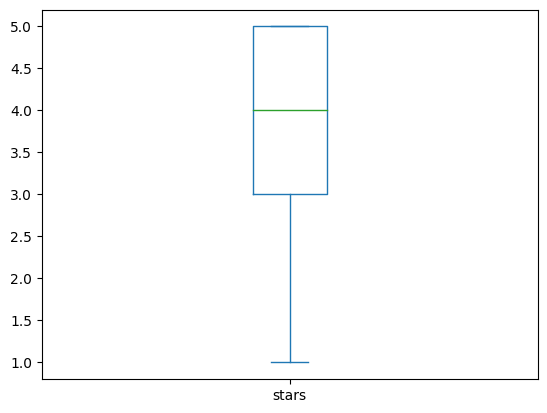

In [97]:
review_user_df.groupby('user_id')['stars'].mean().plot(kind='box')

In [98]:
# early reviews: within month or two after yelping since
youth_threshold = timedelta(days=60)
early_reviews = review_user_df[review_user_df.date - review_user_df.yelping_since < youth_threshold]

early_reviews[['date', 'yelping_since', 'stars', 'user_id']].sample(10)

early_reviews = early_reviews.groupby('user_id').agg(list)
early_reviews.reset_index(inplace=True)
early_reviews['count'] = early_reviews['name'].apply(lambda x: len(x))
early_reviews[early_reviews['count'] >= 3].sample(3)

,user_id,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
186,JCBBmqUxWeEX8Y0tmYgD8g,"[3tJA9OT6UxQFXn6CppTkIw, -3yHFkCcBJ46gcp6wB1yg...","[oUso4QWH1OAXboD8IMjpFQ, OIL90Y4d7Zvko3YwyQUmY...","[4.0, 4.0, 4.0, 4.0]","[2008-12-05 00:00:00, 2008-12-17 00:00:00, 200...",[oh yum. My bf has been wanting good mexican f...,"[2, 0, 3, 3]","[1, 0, 1, 2]","[1, 0, 2, 2]","[Danni, Danni, Danni, Danni]","[152.0, 152.0, 152.0, 152.0]","[2008-11-30 23:42:09, 2008-11-30 23:42:09, 200...","[10.0, 10.0, 10.0, 10.0]","[4.170000076293945, 4.170000076293945, 4.17000...",4
204,Kzp3q208Jl5eyQYVKg0W0A,"[udtKHl_bsDDlq1ihJIpJsw, M9L1_nwaSUrssSfdfPMhb...","[iHQoddqWSJxh61Xp2srj1g, tWiFat101ID5w_wgAPMXh...","[5.0, 4.0, 4.0]","[2009-05-21 00:00:00, 2009-05-20 00:00:00, 200...",[Well what can i say about Rocky's. Its one of...,"[0, 3, 1]","[0, 1, 0]","[0, 2, 1]","[Art, Art, Art]","[55.0, 55.0, 55.0]","[2009-05-16 07:25:19, 2009-05-16 07:25:19, 200...","[7.0, 7.0, 7.0]","[4.420000076293945, 4.420000076293945, 4.42000...",3
334,Yp7_GeD6KTRoo4Nteqv4SA,"[jThHNyO8oHs8CrncwzHhKQ, o6yLz-tcuLe65HhXkjuv1...","[Qit5T2k6_gcu4BH4EYTsVw, sjJOsKnXxsQodXMr1i8fs...","[5.0, 3.0, 2.0, 4.0, 4.0]","[2008-12-04 00:00:00, 2008-12-04 00:00:00, 200...",[Going to the Toronto Island on a summer day i...,"[4, 0, 0, 2, 1]","[1, 0, 1, 2, 0]","[1, 0, 0, 0, 0]","[Melissa, Melissa, Melissa, Melissa, Melissa]","[327.0, 327.0, 327.0, 327.0, 327.0]","[2008-10-12 21:24:42, 2008-10-12 21:24:42, 200...","[14.0, 14.0, 14.0, 14.0, 14.0]","[3.640000104904175, 3.640000104904175, 3.64000...",5


In [99]:
review_bursts = review_user_df.groupby(['user_id', 'date']).agg(list)
review_bursts.reset_index(inplace=True)
review_bursts['count'] = review_bursts['name'].apply(lambda x: len(x))
review_bursts[review_bursts['count'] >= 3].sample(3)

,user_id,date,review_id,business_id,stars,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
7439,wix14bBFkrxWEQCY55Ln0g,2016-12-04,"[3iJFeKGWKr63DCOZOV5Ziw, AcQCEOOvwOz1CHlMlYtUe...","[4GNI7HWuzQkkPmPsgHxOtw, 1QJFpZxLbHbXSKohWp9uI...","[4.0, 4.0, 3.0]",[Always enjoy our meals at Flancers.\n\nPrickl...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[Andrew, Andrew, Andrew]","[63.0, 63.0, 63.0]","[2007-09-09 16:43:31, 2007-09-09 16:43:31, 200...","[3.0, 3.0, 3.0]","[3.5399999618530273, 3.5399999618530273, 3.539...",3
468,3AV5ONopdwL5qKYW20SRdg,2014-02-09,"[PmocRdCBKCY63VBmT7LeeQ, eHTYloJpHUJH7HtbR4Wpv...","[Xs2iTWxbczvfEapAFH3cyw, C0C7IxBSC1df0FwXODZCv...","[4.0, 5.0, 5.0]",[Great food! Nice portions. Featured on the FO...,"[1, 0, 0]","[0, 0, 1]","[0, 0, 0]","[Jenifer, Jenifer, Jenifer]","[340.0, 340.0, 340.0]","[2009-06-23 03:59:59, 2009-06-23 03:59:59, 200...","[41.0, 41.0, 41.0]","[3.890000104904175, 3.890000104904175, 3.89000...",3
3686,TVkU2gHhe05v_lgsE_NccA,2014-12-17,"[moAic4eIThaa8mUuH2dEvw, Fli_03aPJwMycKreZsnQZ...","[JlMYSLiLnpWiihmzZkQS-w, bZ3-_GQZkHv5YI_zzqLNW...","[3.0, 2.0, 5.0, 4.0]","[It's Olive Garden. Always a wait & always, al...","[1, 5, 3, 1]","[0, 2, 0, 1]","[1, 2, 1, 0]","[Nora, Nora, Nora, Nora]","[537.0, 537.0, 537.0, 537.0]","[2010-09-08 21:47:33, 2010-09-08 21:47:33, 201...","[92.0, 92.0, 92.0, 92.0]","[3.7100000381469727, 3.7100000381469727, 3.710...",4


In [122]:
# ~14 years * ~50 weeks
bins_count = 700
review_user_df['date_bin'] = pd.cut(review_user_df['date'], bins=bins_count, labels=range(bins_count))

review_bursts_binned = review_user_df.groupby(['user_id', 'date_bin']).agg(list)
review_bursts_binned.reset_index(inplace=True)
review_bursts_binned = review_bursts_binned.dropna()
review_bursts_binned['count'] = review_bursts_binned['name'].apply(lambda x: len(x))
review_bursts_binned[review_bursts_binned['count'] >= 3].sample(3)

,user_id,date_bin,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,count
1402521,QJI9OSEn6ujRCtrX06vs1w,421,"[aWPdYuXh9imYTz48F18sEQ, u5rJcQ7a_KA2m2y9LQYcr...","[ogpiys3gnfZNZBTEJw5-1Q, 6kkxRV8H9SQLybj0xnEbM...","[4.0, 4.0, 2.0]","[2013-05-07 00:00:00, 2013-05-11 00:00:00, 201...","[When I lived in Vegas (up until 2011), this p...","[2, 4, 2]","[1, 1, 2]","[3, 5, 2]","[J, J, J]","[1981.0, 1981.0, 1981.0]","[2007-03-19 18:15:32, 2007-03-19 18:15:32, 200...","[308.0, 308.0, 308.0]","[3.609999895095825, 3.609999895095825, 3.60999...",3
267142,4LXaLFib9dOAavCN7gnE_g,442,"[JZu-tgICqLkaW4fz9jdldw, wqQ7TiLgRQYEkUwWu67cC...","[aHVhlCvmlNnnPf-LgclNNA, lpxj6LFir23Ds6swW8a6f...","[3.0, 3.0, 1.0]","[2013-10-04 00:00:00, 2013-10-04 00:00:00, 201...",[If you have to eat at the mall this is really...,"[0, 0, 2]","[0, 0, 1]","[0, 1, 0]","[Cass, Cass, Cass]","[928.0, 928.0, 928.0]","[2009-02-26 21:05:06, 2009-02-26 21:05:06, 200...","[61.0, 61.0, 61.0]","[3.059999942779541, 3.059999942779541, 3.05999...",3
2392947,i6V3NyTdkBVwPpH7r2BINA,347,"[IhxaejvgGM7-6j_e7N4TEQ, gT_Jbz5Rll8jXlqJ8ffyn...","[9XLH_grfIYKR7d5ZT9ZX_A, G1BjZ_L_oYchjUTI6A-k7...","[2.0, 5.0, 4.0]","[2011-11-30 00:00:00, 2011-12-03 00:00:00, 201...","[Upon arrival, the place was almost empty exce...","[3, 1, 2]","[1, 0, 1]","[1, 0, 1]","[Tina, Tina, Tina]","[596.0, 596.0, 596.0]","[2009-08-17 16:46:09, 2009-08-17 16:46:09, 200...","[44.0, 44.0, 44.0]","[3.740000009536743, 3.740000009536743, 3.74000...",3


In [131]:
early_reviewers = set(early_reviews['user_id'])
oneday_burst_reviewers = set(review_bursts['user_id'])
oneweek_burst_reviewers = set(review_bursts_binned['user_id'])

print(f'1d / 1w: {len(oneday_burst_reviewers.intersection(oneweek_burst_reviewers))}')
print(f'early / 1w: {len(early_reviewers.intersection(oneweek_burst_reviewers))}')
print(f'early / 1d: {len(early_reviewers.intersection(oneday_burst_reviewers))}')

1d / 1w: 4692
early / 1w: 558
early / 1d: 558
